In [1]:
import numpy as np
seed = 42069
np.random.seed(seed)
import pandas as pd
from matplotlib import pyplot as plt
import arviz
import pystan
from scipy import sparse, stats
from typing import Iterable, Union, Callable
from sklearn.model_selection import train_test_split
import altair as alt
from time import time

# Own files
import utils 
import StanClasses

# Load and preprocess data

The data we have is essentially a matrix, where the each row correspond to a person, and each column correspond to a movie. However, the matrix is very sparse and thus data is stored in sparse format (i.e. specified with indices and the corresponding values). 

In [2]:
# Define constants

DATA_DIR = 'ml-100k'
SM_SIMPLE_NAME = 'sm_simple.stan'

In [3]:
from importlib import reload
reload(utils)

df, _, _ = utils.get_ml100k_data(DATA_DIR, subsample_top_users=150, subsample_top_items=20)
df[['user_id', 'item_id']] -= 1

# We are not going to use timestamp, therefore drop it
df.drop('timestamp', axis='columns', inplace=True)

The user ids and item (movie) ids are essentially integer ranges, starting from and 1 to the number of users and items respectively. We don't have the all the unique ids when subsampling users and movies. It becomes problematic ... TODO: Write this

In [4]:
def column_relabler(df: pd.DataFrame, column: str):
    uniques = pd.value_counts(df[column], sort=False).index.values
    n_uniques = len(uniques)

    # Count from 1 to conform with Stan (Stan counts indexes arrays starting at 1)
    num2id = {num_:id_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    id2num = {id_:num_ for num_, id_ in zip(range(0, n_uniques), uniques)}
    
    df[column] = df[column].map(id2num)
    return id2num, num2id

df_num = df.copy()
user2num, num2user = column_relabler(df_num, 'user_id')
item2num, num2item = column_relabler(df_num, 'item_id')

# p, q represents shape of the matrix as if it was dense
p, q = len(user2num), len(item2num)

In [5]:
df_train, df_valtest = train_test_split(df_num, test_size=50)
df_val, df_test = train_test_split(df_valtest, test_size=25)
del df_valtest

# Matrix Factorization 
Want to factorize the dense matrix $X_{n\times m} \approx U_{n\times k}V_{k\times m}$, where the subscripts denotes matrix shapes. The $k$ dimension denotes the user specified embedding dimension. We use different probabilistic models for the components. 


## Model 1: Simple
Ultra simple

$$ U_{ij} \sim N(\mu_u, \sigma_u) $$
$$ V_{ij} \sim N(\mu_v, \sigma_v) $$
$$ X_{ij}\sim N((UV_{ij}), \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 2: Non-negative Matrix Factorization

$$ U \sim Gamma(\mu_u, \sigma_u) $$
$$ V \sim Gamma(\mu_v, \sigma_v) $$
$$ X_{ij}\sim Gamma(UV_{ij}, \sigma_x)$$

User defined variables:
$\mu_u, \sigma_u, \mu_v, \sigma_v, \sigma_x$

## Model 3: ARD

$$ U \sim N(\mu_u, \alpha_u) $$
$$ V \sim N(\mu_v, \psi_v) $$
$$ X_{ij}\sim N((UV)_{ij}, \beta)$$
$$ \beta \sim Gamma(a, b) $$

$$ \alpha_{ij} \sim Gamma(c, d) $$
$$ \psi_{ij} \sim Gamma(e, f) $$

User defined variables:
$a, b, c, d, e, f$

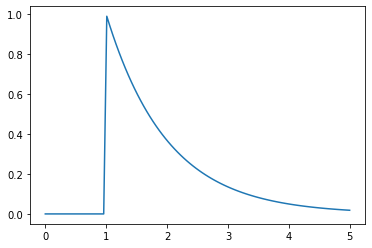

In [6]:
xrange = np.linspace(0,5,100)
plt.plot(xrange, stats.gamma.pdf(xrange, 1, 1))

In [7]:
# sm_simple_code = utils.get_stan_code(SM_SIMPLE_NAME)
# sm_simple = utils.StanModel_cache(sm_simple_code, 'simple')

# data_simple = dict(
#     n_components = 10,
#     n = len(df_train),
#     p=p,
#     q=q,
#     df = df_train,
#     mu_u = 1,
#     sigma_u = 5,
#     mu_v = 1,
#     sigma_v = 5,
#     sigma_x = 1
# )

# control_simple = dict(
#     max_treedepth=20
# )

# t0 = time()
# fit = sm_simple.sampling(data_simple, chains=1, n_jobs=-1, 
#                          iter=2000, control=control_simple, thin=5)
# print(time()-t0)

2K samples, 1 chain, 5 thin

X_hat:            2min 30s, 2min 35, 2min 23s

Array of vectors: 4min 21s, 4min 19s

Matrix, no X_hat: 6min 14s, 6min 5s

In [8]:
sm_simple = StanClasses.SimpleFactorizer(10)

t0 = time()
sm_simple.fit(df_train, chains=1, n_jobs=-1, iter=2000, thin=5, control={'max_treedepth':20})
print(time()-t0)

Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


150.566223859787


(array([2.50236595, 1.89408862, 2.451628  , 1.82229371, 2.64291732,
        2.68266017, 2.34971161, 2.17605432, 2.92078228, 2.17524545,
        2.25250807, 2.49389591, 2.51998732, 2.665248  , 2.86381855,
        2.91635138, 2.16781428, 2.17577952, 2.4562519 , 2.56204482]),
 array([6.50216831, 6.1731075 , 6.64752403, 6.25865892, 7.05138124,
        6.87335544, 6.98899293, 6.73067419, 7.26215611, 6.67151163,
        6.55073536, 7.03023026, 7.02271027, 7.14694583, 7.01039172,
        7.36212744, 6.39853915, 6.73943094, 6.50301576, 6.71459282]))

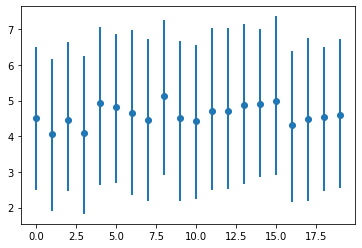

In [9]:
sm_simple.ci(show=True)

In [10]:
Us, Vs = sm_simple.Us, sm_simple.Vs

In [15]:
print(sm_simple.mae(df_train))
print(sm_simple.mae(df_val))
print(sm_simple.mae(df_test))

0.6205422818619017
0.7542698705633484
0.8016767728210531


(1000, 20)


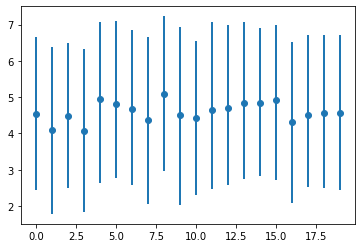

In [20]:
def pizza(*args, **kwargs):
    '''
    The MCMC sampling results with the 3D matrices Us, Vs, which are the sampled factors. 
    
    Let Xs = Us@Vs, this is equivalent to Xs = np.array([U@V for U,V in zip(Us, Vs)])
    '''
    return np.random.normal
    
    
def CredibleIntervals(Us: np.ndarray, Vs: np.ndarray, scale: float=1, 
                      n_elements: int=20, n_samples: int=1000, p=0.95, 
                      show: bool=False, ax: 'AxesObject'=None):
    # Xs is a 3D array
    Xs = Us@Vs
    row_inds, col_inds = np.unravel_index(range(n_elements), Xs.shape[1:])
    
    # P is the first n_elements from randomly selected (with replacement) Us and Vs.
    P = Xs[np.random.randint(0, len(Xs), n_samples)][:,row_inds, col_inds]
    
    P = np.random.normal(loc=P, scale=scale, size=P.shape)
    P.sort(axis=0)
    
    half_p = (1-p)/2
    lb = np.floor((half_p*n_samples)).astype(int)
    ub = np.ceil((p+half_p)*n_samples).astype(int)
    
    lower_bounds, upper_bounds = P[lb], P[ub]

    means = P.mean(0)
    
    if show:
        if ax is None:
            ax = plt.gca()

        ax.errorbar(range(n_elements), means, 
                     yerr=[means-lower_bounds, upper_bounds-means], 
                     fmt='o', linewidth=2)
    
    return lower_bounds, upper_bounds
    

_ = CredibleIntervals(Us, Vs, show=1)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Test Place

In [13]:
raise ValueError

ValueError: 

In [ ]:
sm_test_code = utils.get_stan_code('sanity.stan')
sm_test = utils.StanModel_cache(sm_test_code, 'test')

In [ ]:
fit_test = sm_test.sampling(algorithm="Fixed_param", chains=4, n_jobs=-1, iter=10)

In [ ]:
A = np.array([[0.674531,0.560879],[-1.82799,0.0132566]])

In [ ]:
A@A

In [ ]:
X_ = 